In [40]:
import numpy as np
import pandas as pd
import networkx as nx
import ot
import matplotlib.pyplot as plt
from pyvis.network import Network
import pickle
import os, sys

from constants import ROOT_DIR
# setting the path of this notebook to the root directory
sys.path.append(ROOT_DIR)
# import libraries custom in this repository
import methods.DataIO as DataIO
import methods.GromovWassersteinFramework as GWL
import dev.generate_util as Gen

2023-01-26 13:40:00.974403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


If this is your first run of this notebook, you would want to process the XLSX file containing all of the food web information into CSVs for later. 

In [3]:
DATA_PATH = "/data/Food Web/African_Mammal_FoodWebs.xlsx"
xls = pd.ExcelFile(DATA_PATH)

In [23]:
# Drop unnecessary columns from prey_predator
prey_predator = pd.read_excel(xls, "Predator-Prey", skiprows=8)
omit_cols = ["Notes on prey", "Order", "Family", "Genus", "Mass.g"]
prey_predator.drop(omit_cols, axis=1, inplace=True)
prey_predator.set_index("Prey Species", inplace=True)
prey_predator.fillna(0, inplace=True) # NA entries only for self-references
prey_predator.replace(to_replace=[2.0, 3.0], value=1.0, inplace=True)
prey_predator.head()

,Potamogale_velox,Addax_nasomaculatus,Aepyceros_melampus,Alcelaphus_buselaphus,Ammotragus_lervia,Antidorcas_marsupialis,Beatragus_hunteri,Capra_walie,Cephalophus_adersi,Cephalophus_callipygus,...,Cricetomys_gambianus,Pedetes_capensis,Pedetes_surdaster,Epixerus_ebii,Protoxerus_stangeri,Xerus_inauris,Tachyoryctes_macrocephalus,Thryonomys_gregorianus,Thryonomys_swinderianus,Orycteropus_afer
Prey Species,,,,,,,,,,,,,,,,,,,,,
Potamogale_velox,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Addax_nasomaculatus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aepyceros_melampus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alcelaphus_buselaphus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ammotragus_lervia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
species_location = pd.read_excel(xls, "PA Data")
species_location.drop(["Order", "Family", "Genus"], axis = 1, inplace=True)
species_location.set_index("Species", inplace=True)
species_location.head()

,Aberdare,Abijatta Shalla,Abou Telfane,Addax,Ai Ais,Air and Tenere,Akagera,Amboseli,Ansongo Menaka,Arabuko Sokoke,...,Volcans,Vwaza Marsh,W,Waterberg Plateau,Waza,West Lunga,Yangudi Rassa,Zakouma,Zemongo,Zinave
Species,,,,,,,,,,,,,,,,,,,,,
Potamogale_velox,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Addax_nasomaculatus,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aepyceros_melampus,1,0,0,0,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
Alcelaphus_buselaphus,0,0,1,0,0,0,0,1,0,0,...,0,1,1,1,0,1,0,1,1,0
Ammotragus_lervia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
location2graph = {}
locations = species_location.columns
for location in locations: 
    mask = species_location.loc[:, location] == 1
    species = species_location[mask].index
    location2graph[location] = nx.DiGraph(prey_predator.loc[species, species].T)

In [25]:
min_node = float("inf")
min_web = None
total_nodes = 0

for location in location2graph: 
    G = location2graph[location]
    n = len(G.nodes)
    total_nodes += n
    if min_node > n: 
        min_node = n
        min_web = location
    
print(f"Average number of nodes: {total_nodes / len(location2graph)}")
print(f"Smallest Food Web is in {min_web} with {min_node} animals")
    

Average number of nodes: 51.7
Smallest Food Web is in Banc dArguin with 8 animals


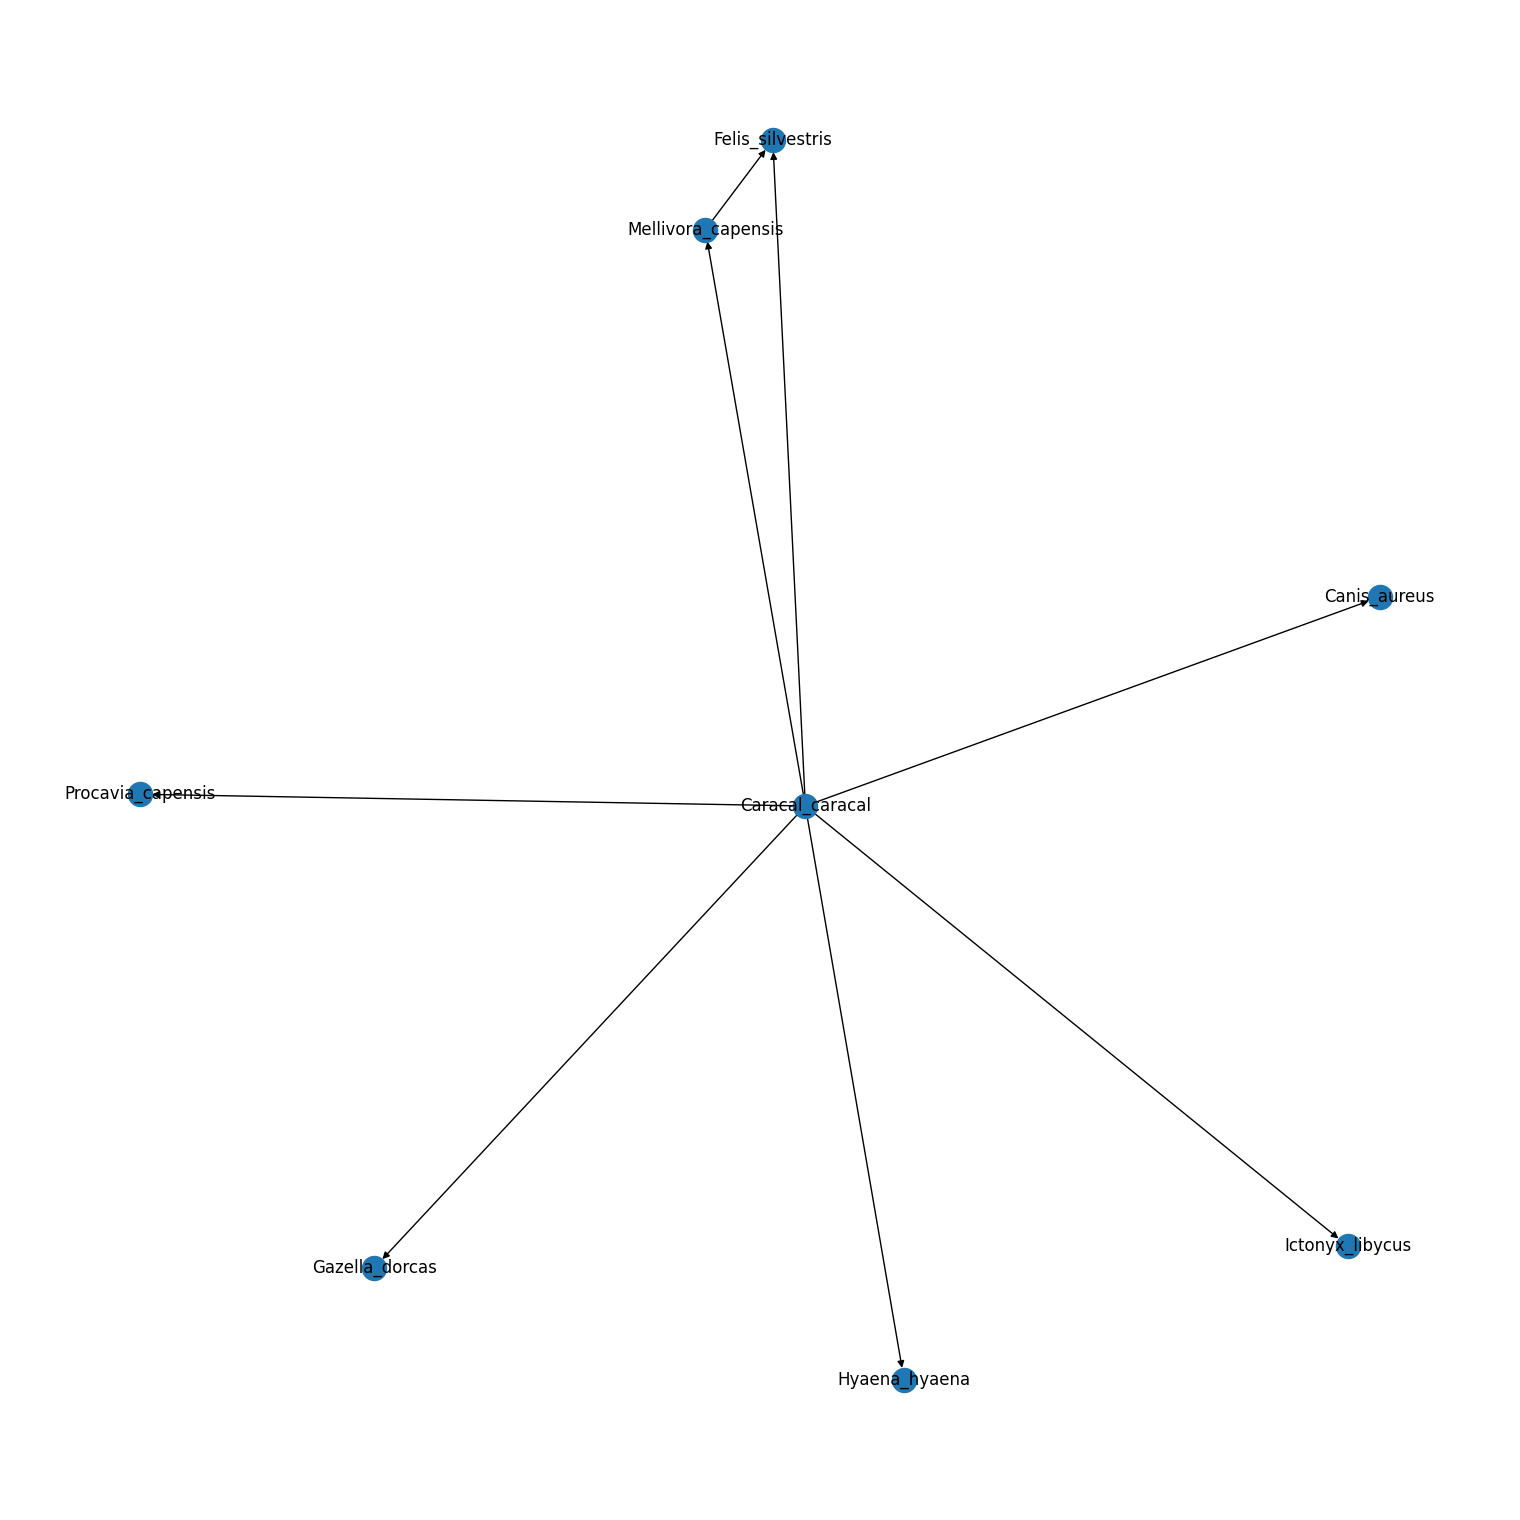

In [83]:
smallest_graph = location2graph["Banc dArguin"]
weight = nx.get_edge_attributes(smallest_graph, "weight").values()
plt.figure(figsize = (15, 15))
nx.draw(smallest_graph, with_labels = True, width=list(weight))

In [30]:
# save the location_to_nx_graph mapping
filename_pkl = os.path.join('/data/Food Web/foodweb_loc2nxgraph.pkl')
with open(filename_pkl, 'wb') as f:
    pickle.dump(location2graph, f)

In [72]:
# run experiment on computing gromov-wasserstein distance for smallest food web
de_id_graph = nx.convert_node_labels_to_integers(smallest_graph)
p, cost, _ = DataIO.extract_graph_info_dense(de_id_graph)
# cost = nx.floyd_warshall_numpy(smallest_graph)
p = p.flatten()
p /= np.sum(p)
nx.to_numpy_array(de_id_graph)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

/usr/local/anaconda3/envs/kai_env/lib/python3.10/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


GW_DIST: 0.02234008084357428


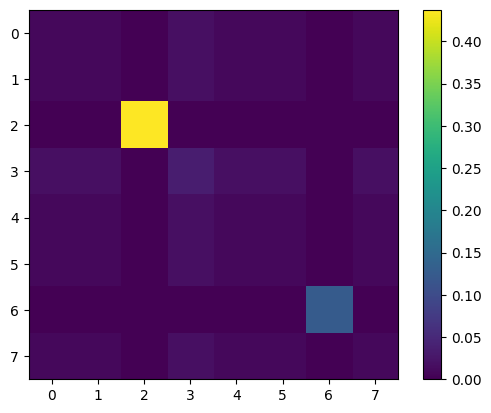

In [94]:
trans, info = ot.gromov.entropic_gromov_wasserstein(cost, cost, p, p, loss_fun="square_loss", epsilon=0.01, log=True, max_iter=5000)
gw_dist = info["gw_dist"]
print(f"GW_DIST: {gw_dist}")
plt.imshow(trans)
plt.colorbar()

GW_DIST: 0.2566167947489713
Sanity Check: We expect that this distance to be greater than the previous.


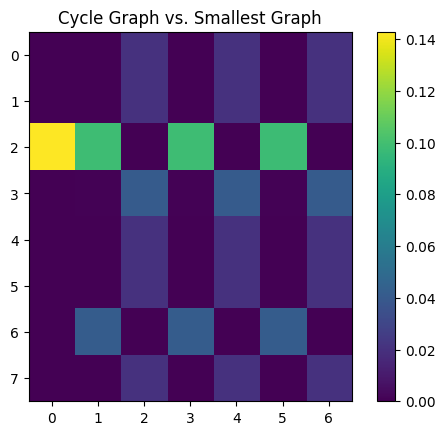

In [95]:
p_t, cost_t, _ = DataIO.extract_graph_info_dense(nx.cycle_graph(7))
p_t = p_t.flatten()
p_t /= np.sum(p_t)


trans, info = ot.gromov.entropic_gromov_wasserstein(cost, cost_t, p, p_t, loss_fun="square_loss", epsilon=0.01, log=True, max_iter=5000)
gw_dist = info["gw_dist"]
print(f"GW_DIST: {gw_dist}")
plt.title("Cycle Graph vs. Smallest Graph")
plt.imshow(trans)
plt.colorbar()
print("Sanity Check: We expect that this distance to be greater than the previous.")

GW_DIST: 3.37842374031536e-100


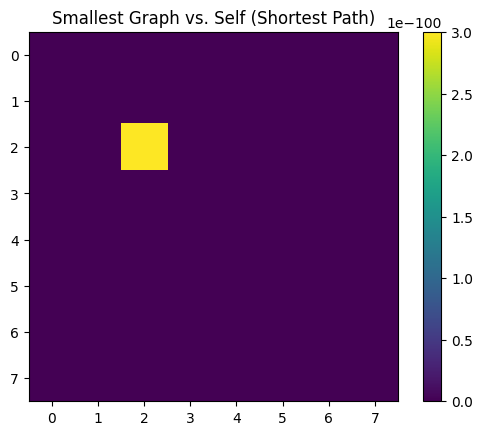

In [98]:
cost_s = nx.floyd_warshall_numpy(de_id_graph)
cost_s[cost_s == np.inf] = 20
cost_t = nx.floyd_warshall_numpy(nx.cycle_graph(7))
cost_t[cost_t == np.inf] = 20

trans, info = ot.gromov.entropic_gromov_wasserstein(cost_s, cost_s, p, p, loss_fun="square_loss", epsilon=0.01, log=True, max_iter=5000)
gw_dist = info["gw_dist"]
print(f"GW_DIST: {gw_dist}")
plt.title("Smallest Graph vs. Self (Shortest Path)")
plt.imshow(trans)
plt.colorbar()

GW_DIST: 0.22899140181979816
Sanity Check: We expect that this distance to be greater than the previous.


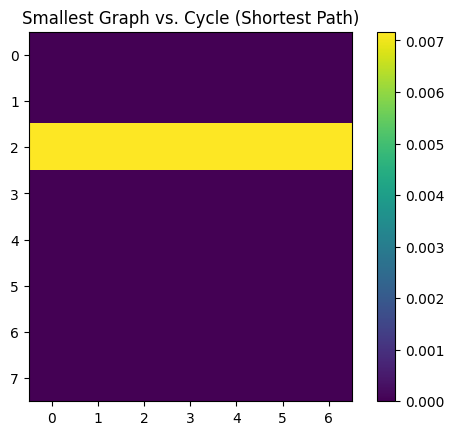

In [91]:
trans, info = ot.gromov.entropic_gromov_wasserstein(cost_s, cost_t, p, p_t, loss_fun="square_loss", epsilon=10, log=True, max_iter=5000)
gw_dist = info["gw_dist"]
print(f"GW_DIST: {gw_dist}")
plt.title("Smallest Graph vs. Cycle (Shortest Path)")
plt.imshow(trans)
plt.colorbar()

print("Sanity Check: We expect that this distance to be greater than the previous.")